# Transfer Learning

The idea here, opposed to the other model with data augmentation, is that you only need to pass the data through the pre-trained model once, because it would be the same every time. This means that we can get the feature vectors out of the pre-trained model and just save those, then build a classifier on top of that data.


In [ ]:
from keras.layers import Input, Dense, Flatten
from keras.layers import RandomFlip, RandomRotation, RandomZoom
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model, Sequential
from keras.utils import image_dataset_from_directory

import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [ ]:
# Downloading data
!wget -nc https://archive.org/download/food-5-k/Food-5K.zip

--2025-03-25 22:43:44--  https://archive.org/download/food-5-k/Food-5K.zip
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ia801606.us.archive.org/13/items/food-5-k/Food-5K.zip [following]
--2025-03-25 22:43:44--  https://ia801606.us.archive.org/13/items/food-5-k/Food-5K.zip
Resolving ia801606.us.archive.org (ia801606.us.archive.org)... 207.241.228.126
Connecting to ia801606.us.archive.org (ia801606.us.archive.org)|207.241.228.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 447001986 (426M) [application/zip]
Saving to: ‘Food-5K.zip’

Food-5K.zip         100%[===================>] 426.29M  4.13MB/s    in 2m 11s  

2025-03-25 22:45:56 (3.26 MB/s) - ‘Food-5K.zip’ saved [447001986/447001986]



In [ ]:
# Unzipping file
!unzip ./Food-5K.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: Food-5K/training/1_1223.jpg  
  inflating: Food-5K/training/1_1237.jpg  
  inflating: Food-5K/training/0_1223.jpg  
  inflating: Food-5K/training/1_349.jpg  
  inflating: Food-5K/training/1_70.jpg  
  inflating: Food-5K/training/1_64.jpg  
  inflating: Food-5K/training/0_628.jpg  
  inflating: Food-5K/training/0_166.jpg  
  inflating: Food-5K/training/1_375.jpg  
  inflating: Food-5K/training/1_413.jpg  
  inflating: Food-5K/training/0_600.jpg  
  inflating: Food-5K/training/1_407.jpg  
  inflating: Food-5K/training/0_614.jpg  
  inflating: Food-5K/training/1_58.jpg  
  inflating: Food-5K/training/0_172.jpg  
  inflating: Food-5K/training/1_361.jpg  
  inflating: Food-5K/training/0_199.jpg  
  inflating: Food-5K/training/0_1009.jpg  
  inflating: Food-5K/training/0_827.jpg  
  inflating: Food-5K/training/0_9.jpg  
  inflating: Food-5K/training/0_833.jpg  
  inflating: Food-5K/training/1_1009.jpg  
  inflating: Food

In [ ]:
# Moving files out of directory
!mv Food-5K/* .

In [ ]:
# Creating new directory organization
!mkdir data
!mkdir data/train
!mkdir data/test
!mkdir data/train/food
!mkdir data/train/non_food
!mkdir data/test/food
!mkdir data/test/non_food

In [ ]:
# Moving the images into directories
!mv training/0*.jpg data/train/non_food
!mv training/1*.jpg data/train/food
!mv validation/0*.jpg data/test/non_food
!mv validation/1*.jpg data/test/food

In [ ]:
# Defining paths
train_path = 'data/train'
valid_path = 'data/test'

In [ ]:
# Setting all image sizes
IMAGE_SIZE = [200, 200]

In [ ]:
# Setting batch size
BATCH_SIZE = 128

In [ ]:
# Creating datasets
train_ds = image_dataset_from_directory(
    train_path,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

val_ds = image_dataset_from_directory(
    valid_path,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 3000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
# Getting class names
class_names = train_ds.class_names

# Setting size of output dim
K = len(class_names)

In [ ]:
# apply preprocess_input
def preprocess(image, label):
    return preprocess_input(image), label


train_ds = train_ds.map(preprocess)
val_ds = val_ds.map(preprocess)

In [ ]:
# Caching dataset
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Instantiating pre-trained model
vgg_16 = VGG16(
    input_shape=IMAGE_SIZE + [3],
    weights='imagenet',
    include_top=False,
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
# Flattening the model's output
x = Flatten()(vgg_16.output)

Flattening the models features from a 4D array (batch, height, width, channels), into a 1D array (batch, features) array for each image. We do this so the feature vector can be used by traditional classifiers, such as Logistic Regression.


In [ ]:
# Creating model
model = Model(vgg_16.input, x)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 200, 200, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 200, 200, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 100, 100, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 100, 100, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 100, 100, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 50, 50, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 50, 50, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 50, 50, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 50, 50, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 25, 25, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 25, 25, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 25, 25, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 25, 25, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Getting feature array
X_train = model.predict(train_ds)
X_val = model.predict(val_ds)

24/24 ━━━━━━━━━━━━━━━━━━━━ 44s 772ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step


This is a very important part, where we pass the images through the training and validation sets, obtaining feature vectors


In [ ]:
# Getting number of features extracted from each image
D = X_train.shape[1]

In [ ]:
# Extracting labels from dataset
Y_train = np.concatenate([y for x, y in train_ds])
Y_val = np.concatenate([y for x, y in val_ds])

In [ ]:
# Scaling data
scaler = StandardScaler()

X_train_2 = scaler.fit_transform(X_train)
X_val_2 = scaler.transform(X_val)

In [ ]:
# Logistic regression with sklearn
log_r = LogisticRegression()
log_r.fit(X_train_2, Y_train)

# Checking scores
log_r.score(X_train_2, Y_train), log_r.score(X_val_2, Y_val)

(1.0, 0.982)

In [ ]:
# Logistic Regression with TensorFlow
i = Input(shape=(D,))
x = Dense(1, activation='sigmoid')(i)

linear_model = Model(i, x)

In [ ]:
# Compiling model
linear_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

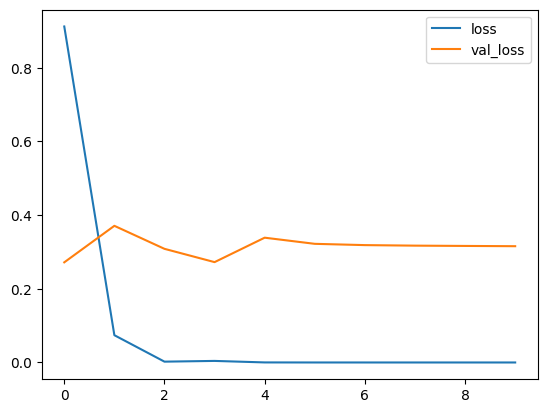

In [ ]:
# Plotting loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [ ]:
# Training model
r = linear_model.fit(
    X_train,
    Y_train,
    batch_size=BATCH_SIZE,
    epochs=10,
    validation_data=(X_val, Y_val),
)

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8618 - loss: 1.6662 - val_accuracy: 0.9810 - val_loss: 0.2718
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9875 - loss: 0.1023 - val_accuracy: 0.9780 - val_loss: 0.3709
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 0.0010 - val_accuracy: 0.9780 - val_loss: 0.3084
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9996 - loss: 0.0025 - val_accuracy: 0.9790 - val_loss: 0.2724
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0918e-04 - val_accuracy: 0.9740 - val_loss: 0.3387
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.9299e-06 - val_accuracy: 0.9740 - val_loss: 0.3220
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.3164e-06 - val_accuracy: 0.9740 - val_loss: 0.3185
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.2100e-06 - val_accuracy: 0

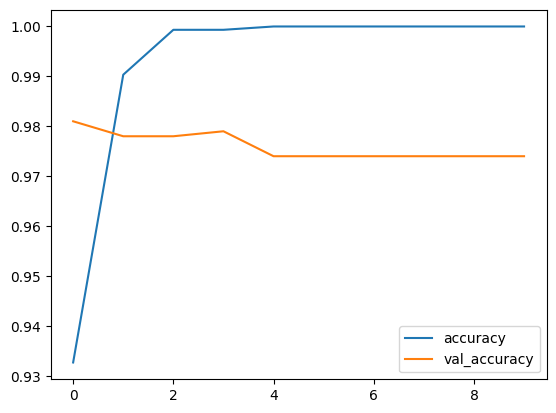

In [ ]:
# Plotting accuracy
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()